In [270]:
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql import SparkSession

# instantiate SparkSession object
# spark = SparkSession.builder.master('local').getOrCreate()

spark = SparkSession\
        .builder\
        .appName('ALSExample').config('spark.driver.host', 'localhost')\
        .getOrCreate()

In [271]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
import pyspark as spark
spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

In [272]:
reviews = pd.read_csv('../../data/raw/ratings.csv')
links = pd.read_csv('../../data/raw/links.csv')
movies = pd.read_csv('../../data/raw/movies.csv')
tags = pd.read_csv('../../data/raw/tags.csv')

In [12]:
reviews.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


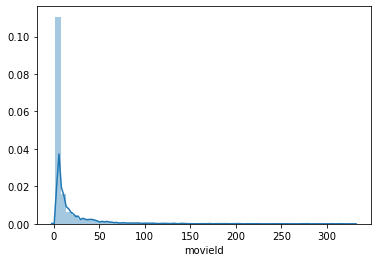

In [11]:
sns.distplot(reviews.movieId.value_counts())

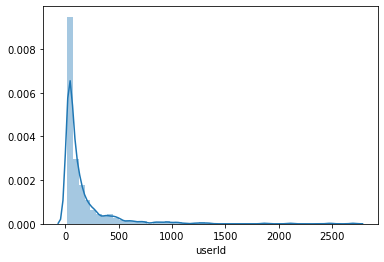

In [13]:
sns.distplot(reviews.userId.value_counts())

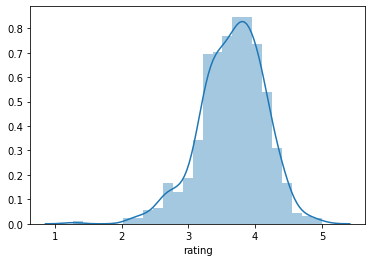

In [15]:
sns.distplot(reviews.groupby('userId')['rating'].mean())

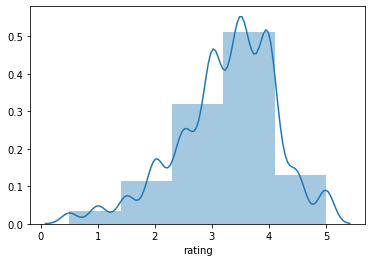

In [23]:
sns.distplot(reviews.groupby('movieId')['rating'].mean(),bins=5)

In [27]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [32]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

In [48]:
movies

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]"


# Spark ALS Model

In [262]:
movie_ratings = spark.read.csv('../../data/raw/ratings.csv', header='true', inferSchema='true')
movie_titles = spark.read.csv('../../data/raw/movies.csv', header='true', inferSchema='true')
movie_ratings = movie_ratings.drop('timestamp')

In [266]:
# split into training and testing sets
(training, test) = movie_ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5,rank=5, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating',
          coldStartStrategy='drop')

# fit the ALS model to the training set
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))

Root-mean-square error = 1.0056321673243596


In [268]:
predictions.show(5)

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   597|    471|   2.0| 4.0301857|
|   555|    471|   3.0|  3.685633|
|   373|    471|   5.0|  3.792108|
|   104|    471|   4.5| 4.0643325|
|   307|    833|   1.0| 1.6960754|
+------+-------+------+----------+
only showing top 5 rows



In [264]:
# Train a model on to predict user-product ratings
# model = ALS.fit(training)

# Get predicted ratings on all existing user-product pairs
testData = movie_ratings.map(lambda p: (p.userId, p.movieId))
predictions = model.predictAll(testData).map(lambda r: ((r.userId, r.movieId), r.rating))

ratingsTuple = ratings.map(lambda r: ((r.userId, r.movieId), r.rating))
scoreAndLabels = predictions.join(ratingsTuple).map(lambda tup: tup[1])

# Instantiate regression metrics to compare predicted and actual ratings
metrics = RegressionMetrics(scoreAndLabels)

AttributeError: 'DataFrame' object has no attribute 'map'

In [252]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))

Root-mean-square error = 0.9904863008267943


In [248]:
predictions = model.transform(test)
predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|    91|    471|   1.0|  2.891528|
|   217|    471|   2.0| 2.7812574|
|   520|    471|   5.0| 3.4742522|
|   216|    471|   3.0|  2.771472|
|   469|    471|   5.0| 3.6602752|
|   414|    471|   5.0| 3.1833572|
|   373|    471|   5.0| 3.1041133|
|    44|    833|   2.0| 2.7081106|
|   608|    833|   0.5| 1.7920616|
|    20|   1088|   4.5|  4.229683|
|   583|   1088|   3.5| 3.6352441|
|   307|   1088|   3.0|  2.413219|
|    10|   1088|   3.0| 4.0726886|
|   414|   1088|   3.0| 2.9383802|
|    42|   1088|   3.0|  3.261031|
|   104|   1088|   3.0| 3.9404857|
|    19|   1238|   3.0| 3.7440336|
|    19|   1342|   2.0| 2.7077537|
|   387|   1342|   3.0| 2.2485914|
|   307|   1342|   2.0| 0.4112938|
+------+-------+------+----------+
only showing top 20 rows



In [217]:
def collab_is_rel(recs, uid, ratings_df):
    """takes output from our collaborative filter and tests to see if they are relevant
    by looking at the true rating given by a user"""
    rec_ids = []
    relative = []
    for rec in recs:
        rec_ids.append(rec[1])
    for movie in rec_ids:
        relative.append(ratings_df.loc[(ratings_df.userId == uid) & (ratings_df.movieId == movie)])
    return relative

In [218]:
collab_is_rel(recs, 1, reviews)

[Empty DataFrame
 Columns: [userId, movieId, rating]
 Index: [], Empty DataFrame
 Columns: [userId, movieId, rating]
 Index: [], Empty DataFrame
 Columns: [userId, movieId, rating]
 Index: [], Empty DataFrame
 Columns: [userId, movieId, rating]
 Index: [], Empty DataFrame
 Columns: [userId, movieId, rating]
 Index: []]

In [207]:
reviews.loc[(reviews.userId == 1) & (reviews.movieId == 48394)]

,userId,movieId,rating


In [210]:
reviews.loc[reviews.movieId == 7147]

,userId,movieId,rating
2020,18,7147,4.5
3719,22,7147,0.5
7742,51,7147,4.0
9875,64,7147,4.0
10300,66,7147,5.0
...,...,...,...
91110,590,7147,3.0
95748,600,7147,3.5
98229,606,7147,4.0
99413,608,7147,4.0


In [19]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [35]:
# initialize the ALS model
als_model = ALS(userCol='userId', itemCol='movieId', 
                ratingCol='rating', coldStartStrategy='drop')

# create the parameter grid                 
params = ParamGridBuilder()\
          .addGrid(als_model.regParam, [0.01, 0.001, 0.1])\
          .addGrid(als_model.rank, [4, 10, 50]).build()


# instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)
best_model = cv.fit(movie_ratings)    

# We see the best model has a rank of 50, so we will use that in our future models with this dataset
best_model.bestModel.rank

50

In [180]:
def name_retriever(movie_id, movie_title_df):
    return movie_title_df.where(movie_title_df.movieId == movie_id).take(1)[0]['title']

def new_user_recs(user_id, new_ratings, rating_df, movie_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
    new_user_ratings = spark.createDataFrame(new_ratings,rating_df.columns)
    
    # combine the new ratings df with the rating_df
    movie_ratings_combined = rating_df.union(new_user_ratings)
    
    # split the dataframe into a train and test set
#     (training, test) = movie_ratings_combined.randomSplit([0.8, 0.2],seed=0)
    
    # create an ALS model and fit it
    als = ALS(maxIter=5,rank=50, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy='drop')
    model = als.fit(movie_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
    recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)
    
    # returns a list of recommended movies
    recs_list = []
    for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
        movie_string = name_retriever(movie_id,movie_title_df)
        recs_list.append((ranking+1,movie_id,movie_string,rating))
    return recs_list

In [160]:
name_retriever(2, movie_titles)

'Jumanji (1995)'

In [215]:
user_id = 1
user_ratings_1 = [(user_id,1,5),
                  (user_id,2,5),
                  (user_id,50,4),
                  (user_id,1000,1),
                  (user_id,599,5),
                  (user_id,666,1)]
recs = new_user_recs(user_id,
             new_ratings=user_ratings_1,
             rating_df=movie_ratings,
             movie_title_df=movie_titles,
             num_recs = 5)

In [216]:
recs

[(1, 1262, 'Great Escape, The (1963)', 6.022373676300049),
 (2, 46578, 'Little Miss Sunshine (2006)', 5.977536201477051),
 (3, 122882, 'Mad Max: Fury Road (2015)', 5.904064655303955),
 (4,
  750,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)',
  5.899744987487793),
 (5, 85881, 'Win Win (2011)', 5.846571445465088)]

# Making movie content filtering system

In [273]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

In [274]:
movies = pd.read_csv('../../data/raw/movies.csv')

In [275]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
movies['year'] = movies['title'].apply(lambda x: x[-5:-1].strip('('))
movies['year'] = movies['year'].apply(lambda x: x.strip(')'))
movies['year'] = movies['year'].apply(lambda x: x.strip('-'))
movies = movies.drop(movies[movies['title'].str.contains("\(") == False].index)

In [276]:
from sklearn.preprocessing import MultiLabelBinarizer

In [161]:
# mlb = MultiLabelBinarizer()

# res = pd.DataFrame(mlb.fit_transform(movies['genres']),
#                    columns=mlb.classes_,
#                    index=movies['genres'].index)

In [162]:
genre_reviews = pd.merge(movies, res, left_index = True, right_index = True)

In [164]:
genre_reviews = genre_reviews.drop(['genres'], axis = 1)

In [277]:
tags = pd.read_csv('../../data/raw/tags.csv')

In [278]:
tags['joined_tags'] = tags.groupby('movieId')['tag'].transform(lambda x: ' '.join(x))

In [279]:
tags

,userId,movieId,tag,timestamp,joined_tags
0,2,60756,funny,1445714994,funny Highly quotable will ferrell comedy funn...
1,2,60756,Highly quotable,1445714996,funny Highly quotable will ferrell comedy funn...
2,2,60756,will ferrell,1445714992,funny Highly quotable will ferrell comedy funn...
3,2,89774,Boxing story,1445715207,Boxing story MMA Tom Hardy
4,2,89774,MMA,1445715200,Boxing story MMA Tom Hardy
...,...,...,...,...,...
3678,606,7382,for katie,1171234019,adolescence crime for katie
3679,606,7936,austere,1173392334,austere
3680,610,3265,gun fu,1493843984,gun fu heroic bloodshed
3681,610,3265,heroic bloodshed,1493843978,gun fu heroic bloodshed


In [280]:
tags = tags[['movieId', 'joined_tags']].drop_duplicates()

In [281]:
tags

,movieId,joined_tags
0,60756,funny Highly quotable will ferrell comedy funn...
3,89774,Boxing story MMA Tom Hardy
6,106782,drugs Leonardo DiCaprio Martin Scorsese Stock ...
9,48516,way too long Leonardo DiCaprio suspense twist ...
10,431,Al Pacino gangster mafia
...,...,...
3674,1948,British
3676,5694,70mm
3677,6107,World War II
3679,7936,austere


In [203]:
tags.loc[tags.movieId == 1]

,movieId,joined_tags
629,1,"pixar, pixar, fun"


In [282]:
avg_review = pd.DataFrame(reviews.groupby('movieId')['rating'].mean())

In [283]:
avg_review['no_of_ratings'] = reviews.groupby('movieId')['rating'].count()

In [284]:
movies_ratings = genre_reviews.merge(avg_review, how = 'inner', on = 'movieId')

NameError: name 'genre_reviews' is not defined

# NLTK

In [285]:
from nltk import *
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [286]:
from rake_nltk import Rake

In [287]:
movies_w_tags = movies.merge(tags, on='movieId')

In [288]:
movies_w_tags['genres'] = movies_w_tags['genres'].apply(lambda x: ' '.join([str(elem) for elem in x]) )

In [289]:
movies_w_tags['joined_tags'] = movies_w_tags['joined_tags'].apply(lambda x: x.replace(',', ''))

In [290]:
movies_w_tags['keywords'] = movies_w_tags['genres'] +' '+ movies_w_tags['joined_tags']

In [291]:
movies_w_tags

,movieId,title,genres,year,joined_tags,keywords
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1995,pixar pixar fun,Adventure Animation Children Comedy Fantasy pi...
1,2,Jumanji (1995),Adventure Children Fantasy,1995,fantasy magic board game Robin Williams game,Adventure Children Fantasy fantasy magic board...
2,3,Grumpier Old Men (1995),Comedy Romance,1995,moldy old,Comedy Romance moldy old
3,5,Father of the Bride Part II (1995),Comedy,1995,pregnancy remake,Comedy pregnancy remake
4,7,Sabrina (1995),Comedy Romance,1995,remake,Comedy Romance remake
...,...,...,...,...,...,...
1566,183611,Game Night (2018),Action Comedy Crime Horror,2018,Comedy funny Rachel McAdams,Action Comedy Crime Horror Comedy funny Rachel...
1567,184471,Tomb Raider (2018),Action Adventure Fantasy,2018,adventure Alicia Vikander video game adaptation,Action Adventure Fantasy adventure Alicia Vika...
1568,187593,Deadpool 2 (2018),Action Comedy Sci-Fi,2018,Josh Brolin Ryan Reynolds sarcasm,Action Comedy Sci-Fi Josh Brolin Ryan Reynolds...
1569,187595,Solo: A Star Wars Story (2018),Action Adventure Children Sci-Fi,2018,Emilia Clarke star wars,Action Adventure Children Sci-Fi Emilia Clarke...


### Count Vectorizer

In [253]:
# movies_w_tags['joined_tags'] = movies_w_tags['joined_tags'].apply(lambda x: x.split(', '))

In [255]:
# movies_w_tags['keywords'] = movies_w_tags['genres']+movies_w_tags['joined_tags']

In [292]:
movies_w_tags = movies_w_tags.drop(['joined_tags'], axis=1)

In [293]:
movies_w_tags['genres'] = movies_w_tags['genres'].apply(lambda x: x.split(' '))

In [294]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [295]:
count_vect = CountVectorizer(stop_words='english')
counts = count_vect.fit_transform(movies_w_tags.keywords)

In [296]:
count_vect.vocabulary_

{'adventure': 36,
 'animation': 75,
 'children': 274,
 'comedy': 317,
 'fantasy': 530,
 'pixar': 1140,
 'fun': 587,
 'magic': 923,
 'board': 177,
 'game': 595,
 'robin': 1261,
 'williams': 1649,
 'romance': 1269,
 'moldy': 990,
 'old': 1079,
 'pregnancy': 1170,
 'remake': 1233,
 'drama': 453,
 'politics': 1154,
 'president': 1173,
 'crime': 363,
 'mafia': 921,
 'jane': 810,
 'austen': 110,
 'thriller': 1514,
 'hollywood': 712,
 'horror': 724,
 'mystery': 1023,
 'serial': 1332,
 'killer': 852,
 'alcoholism': 49,
 'shakespeare': 1342,
 'netflix': 1046,
 'queue': 1199,
 'sci': 1309,
 'fi': 547,
 'kidnapping': 850,
 'high': 695,
 'school': 1307,
 'teacher': 1485,
 'time': 1522,
 'travel': 1545,
 'brad': 194,
 'pitt': 1139,
 'bruce': 211,
 'willis': 1650,
 'mindfuck': 978,
 'post': 1161,
 'apocalyptic': 84,
 'twist': 1562,
 'ending': 491,
 'animal': 73,
 'movie': 1010,
 'pigs': 1137,
 'villain': 1602,
 'nonexistent': 1061,
 'needed': 1038,
 'good': 626,
 'story': 1429,
 'death': 399,
 'pena

In [297]:
cos_sim = cosine_similarity(counts, counts)

In [298]:
indices = pd.Series(movies_w_tags.index)

In [299]:
def recommendations(title, cos_sim = cos_sim):
    
    # initializing the empty list of recommended movies
    recommended_movies = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cos_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(movies_w_tags.index)[i])
        
    return recommended_movies

In [300]:
recommendations(0)

[544, 666, 1033, 812, 643, 160, 1444, 1281, 1274, 248]

## TFIDF

In [317]:
vectorizer = TfidfVectorizer(stop_words = 'english')

In [318]:
X = vectorizer.fit_transform(movies_w_tags.keywords)

In [319]:
tfidf_cos = cosine_similarity(X, X)

In [320]:
recommendations(1)

[1352, 875, 939, 1402, 1491, 1567, 1210, 1033, 1515, 1444]

In [305]:
def tfidf_recs(title, cos_sim = tfidf_cos):
    
    # initializing the empty list of recommended movies
    recommended_movies = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cos_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:21].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(movies_w_tags.index)[i])
        
    return title, recommended_movies

In [321]:
tfidf_recs(2959)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [314]:
def genre_choose(rec_outputs, movies):
    match_list = []
#     count = 0
    original_movie_genres = movies.loc[movies.index == rec_outputs[0]]['genres'][(rec_outputs[0])]
    for i in rec_outputs[1]:
        movie = movies.loc[movies.index == i]['genres'].values[0]
        for genre in movie:
#             count = 0
            for genrez in original_movie_genres:
#                 count = 0
#                 print(genrez)
#                 print(genre)
                if genrez == genre:
                    match_list.append(movies[movies.index == i]['title'])
#                     print(count)
#                     count = count + 1
    return match_list
            
            

In [331]:
movies_w_tags.loc[movies_w_tags['title'].str.contains('Citizen Kane') ]

,movieId,title,genres,year,keywords
205,923,Citizen Kane (1941),"[Drama, Mystery]",1941,Drama Mystery Rosebud


In [332]:
tfidf_recs(205)

(205,
 [369,
  911,
  752,
  448,
  460,
  1413,
  603,
  564,
  749,
  990,
  172,
  418,
  1200,
  870,
  524,
  26,
  885,
  975,
  230,
  1273])

In [336]:
movies_w_tags.iloc[448,:]

movieId                              1913
title       Picnic at Hanging Rock (1975)
genres                   [Drama, Mystery]
year                                 1975
keywords          Drama Mystery Australia
Name: 448, dtype: object

In [315]:
# print(movies_w_tags.loc[movies_w_tags.index == 758])
genre_choose(tfidf_recs(2959), movies_w_tags)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [441]:
movies.loc[movies.index == 1281]


,movieId,title,genres,year
1281,1701,Deconstructing Harry (1997),"[Comedy, Drama]",1997


In [443]:
recommendations(0)

[544, 666, 1033, 812, 643, 160, 1444, 1281, 1274, 248]

## SURPRISE

In [33]:
reviews.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [51]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split, cross_validate
from surprise import BaselineOnly
from surprise import Reader
from surprise import NormalPredictor
from surprise import KNNWithMeans, KNNBasic

In [44]:
reviews

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [45]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(reviews[['userId', 'movieId', 'rating']], reader)

In [47]:
cross_validate(NormalPredictor(), data, cv=2)

{'test_rmse': array([1.42512046, 1.43264658]),
 'test_mae': array([1.13868738, 1.14502232]),
 'fit_time': (0.07204604148864746, 0.08701634407043457),
 'test_time': (0.5408182144165039, 0.7999539375305176)}

In [48]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8777


0.8776667207396666

In [52]:
algo2 = KNNBasic()
algo2.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [56]:
uid = str(196)  # raw user id (as in the ratings file). They are **strings**!
iid = str(302)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, verbose=True)

user: 196        item: 302        r_ui = None   est = 3.50   {'was_impossible': False}


In [145]:
algo.predict

AttributeError: 'Prediction' object has no attribute 'verbose'

In [57]:
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
import numpy as np

In [58]:
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)

In [65]:
g_s_svd.best_score

{'rmse': 0.8694374724135923, 'mae': 0.6678960167405232}

In [66]:
g_s_svd.best_params

{'rmse': {'n_factors': 20, 'reg_all': 0.02},
 'mae': {'n_factors': 20, 'reg_all': 0.02}}

In [67]:
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [68]:
for i in cv_knn_basic.items():
    print(i)

('test_rmse', array([0.97370606, 0.97991646, 0.97655098, 0.96374814, 0.9737196 ]))
('test_mae', array([0.75378862, 0.75380667, 0.75169519, 0.74518312, 0.75344728]))
('fit_time', (0.5691049098968506, 0.5580248832702637, 0.5404531955718994, 0.5686569213867188, 0.5845341682434082))
('test_time', (1.491178035736084, 1.4485602378845215, 1.424595832824707, 1.511796236038208, 1.592658281326294))


In [69]:
# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [70]:
for i in cv_knn_baseline.items():
    print(i)

('test_rmse', array([0.87945638, 0.88004591, 0.88153581, 0.87201126, 0.87869311]))
('test_mae', array([0.67071738, 0.672286  , 0.67082321, 0.66602136, 0.67184505]))
('fit_time', (0.7851588726043701, 0.8141403198242188, 0.7857329845428467, 0.805516242980957, 0.8337271213531494))
('test_time', (2.1990649700164795, 2.1503360271453857, 2.1291491985321045, 2.1436309814453125, 2.143622875213623))


In [132]:
user_rating = [{'userId': 1000, 'movieId': 55245, 'rating': '5'},
 {'userId': 1000, 'movieId': 2491, 'rating': '4'},
 {'userId': 1000, 'movieId': 4718, 'rating': '4'},
 {'userId': 1000, 'movieId': 5990, 'rating': '3'},
 {'userId': 1000, 'movieId': 277, 'rating': '0.5'}             ]

In [142]:
movies.loc[movies['movieId'] == 5990]

,movieId,title,genres,year
4160,5990,Pinocchio (2002),ChildrenComedyFantasy,2002


In [133]:
## add the new ratings to the original ratings DataFrame
new_ratings_df = reviews.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [149]:
new_ratings_df.rating.value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
4          2
5          1
3          1
0.5        1
Name: rating, dtype: int64

In [134]:
# train a model using the new combined DataFrame
svd_ = SVD(n_factors= 20, reg_all=0.02)
svd_.fit(new_data.build_full_trainset())

In [150]:
list_of_movies = []
for m_id in reviews['movieId'].unique():
    list_of_movies.append( (m_id,svd_.predict(1000,m_id)[3]))

In [148]:
list_of_movies

[(1, 3.8295001028465534),
 (3, 3.153323571607524),
 (6, 3.804551641531655),
 (47, 3.9367469180872403),
 (50, 4.171187436874287),
 (70, 3.5805341516780875),
 (101, 3.923127945919079),
 (110, 3.9979074334601568),
 (151, 3.621525338687688),
 (157, 3.225140224333514),
 (163, 3.5120826985296487),
 (216, 3.4621753999391514),
 (223, 3.8422623707416403),
 (231, 3.0378537167681636),
 (235, 3.6007372927776355),
 (260, 4.239702028417346),
 (296, 3.9925227715738556),
 (316, 3.2951012260646237),
 (333, 3.7737722117648937),
 (349, 3.5186023189369466),
 (356, 4.256461039461516),
 (362, 3.468903181931522),
 (367, 2.9948263309944045),
 (423, 3.1443593098311573),
 (441, 4.001928772882501),
 (457, 4.0287435761836035),
 (480, 3.781553527339033),
 (500, 3.3465323794958586),
 (527, 4.1134722249222255),
 (543, 3.4705773835618543),
 (552, 3.2062671859066376),
 (553, 3.8490547195669342),
 (590, 3.632325530577746),
 (592, 3.3728099216814935),
 (593, 3.964693111721107),
 (596, 3.497836426682377),
 (608, 3.860318

In [137]:
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [119]:
movies['genres'] = movies['genres'].apply(lambda x: ''.join([str(elem) for elem in x]))

In [120]:
movies

,movieId,title,genres,year
0,1,Toy Story (1995),AdventureAnimationChildrenComedyFantasy,1995
1,2,Jumanji (1995),AdventureChildrenFantasy,1995
2,3,Grumpier Old Men (1995),ComedyRomance,1995
3,4,Waiting to Exhale (1995),ComedyDramaRomance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),ActionAnimationComedyFantasy,2017
9738,193583,No Game No Life: Zero (2017),AnimationComedyFantasy,2017
9739,193585,Flint (2017),Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),ActionAnimation,2018


In [138]:
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies,5)

Recommendation #  1 :  277    Shawshank Redemption, The (1994)
Name: title, dtype: object 

Recommendation #  2 :  6315    Departed, The (2006)
Name: title, dtype: object 

Recommendation #  3 :  602    Dr. Strangelove or: How I Learned to Stop Worr...
Name: title, dtype: object 

Recommendation #  4 :  906    Lawrence of Arabia (1962)
Name: title, dtype: object 

Recommendation #  5 :  4909    Eternal Sunshine of the Spotless Mind (2004)
Name: title, dtype: object 



In [121]:
def movie_rater(movie_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list      

In [122]:
movie_rater(movies, 6, 'Comedy')

      movieId                    title             genres  year
3221     4350  Forgotten Silver (1996)  ComedyDocumentary  1996
How do you rate this movie on a scale of 1-5, press n if you have not seen :
1
      movieId                                    title                 genres  \
3363     4571  Bill & Ted's Excellent Adventure (1989)  AdventureComedySci-Fi   

      year  
3363  1989  
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
     movieId                              title         genres  year
256      295  Pyromaniac's Love Story, A (1995)  ComedyRomance  1995
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId                         title       genres  year
4950     7460  Coffee and Cigarettes (2003)  ComedyDrama  2003
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
      movieId                         title         genres  year
2087     2774  Better Than Chocolate (

[{'userId': 1000, 'movieId': 4350, 'rating': '1'},
 {'userId': 1000, 'movieId': 4571, 'rating': '5'},
 {'userId': 1000, 'movieId': 7460, 'rating': '5'},
 {'userId': 1000, 'movieId': 370, 'rating': '5'},
 {'userId': 1000, 'movieId': 61024, 'rating': '5'},
 {'userId': 1000, 'movieId': 4886, 'rating': '5'}]

In [123]:
user_rating = [{'userId': 1000, 'movieId': 4350, 'rating': '1'},
 {'userId': 1000, 'movieId': 4571, 'rating': '5'},
 {'userId': 1000, 'movieId': 7460, 'rating': '5'},
 {'userId': 1000, 'movieId': 370, 'rating': '5'},
 {'userId': 1000, 'movieId': 61024, 'rating': '5'},
 {'userId': 1000, 'movieId': 4886, 'rating': '5'}]

In [151]:
reviews

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0
